# Carga, limpieza y análisis de los datos del tráfico diario

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dbfread import DBF
import geopandas as gpd
import datetime
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = "Data_input/Historico datos trafico"
traffic_data_files = glob.glob(path + '/*.csv')
traffic_data_files

['Data_input/Historico datos trafico\\01-2022.csv',
 'Data_input/Historico datos trafico\\02-2022.csv',
 'Data_input/Historico datos trafico\\03-2022.csv',
 'Data_input/Historico datos trafico\\04-2022.csv',
 'Data_input/Historico datos trafico\\05-2022.csv',
 'Data_input/Historico datos trafico\\06-2022.csv',
 'Data_input/Historico datos trafico\\07-2022.csv',
 'Data_input/Historico datos trafico\\08-2022.csv',
 'Data_input/Historico datos trafico\\09-2022.csv',
 'Data_input/Historico datos trafico\\10-2022.csv',
 'Data_input/Historico datos trafico\\11-2022.csv',
 'Data_input/Historico datos trafico\\12-2022.csv']

In [3]:
path_datos = "Data_input/Historico puntos trafico"
traffic_points_files = glob.glob(path_datos + '/*.csv')
traffic_points_files

['Data_input/Historico puntos trafico\\pmed_ubicacion_01-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_02-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_03-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_04-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_05-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_06-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_07-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_08-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_09-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_10-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_11-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_12-2022.csv']

In [4]:
meses = list(range(1, 13))

horas_dia = [6,7,8,9,10,11,12,13,14,15,16,17]
horas_tarde = [18,19,20,21]
horas_noche = [22,23,0,1,2,3,4,5]

vehiculos_pesados = 0.0862
vehiculos_ligeros = 1 - vehiculos_pesados

crs = "EPSG:25830"

In [15]:
def transformacion_datos_trafico(fichero_intensidad, fichero_puntos, mes):
    # Lectura del fichero
    traffic_mes = pd.read_csv(fichero_intensidad, sep=";")
    
    traffic_mes = traffic_mes[['id', 'fecha', 'tipo_elem', 'intensidad']]
    
    # Se eliminan los id con valores únicos de intensidad < 30
    traffic_mes_2 = traffic_mes[traffic_mes
                                  .groupby('id')['intensidad']
                                  .transform('nunique') >= 30]
    
    # Se transforma el tipo de la columna fecha
    traffic_mes_2['fecha'] = pd.to_datetime(traffic_mes_2['fecha'])
    # Se crean los atributos: mes, dia, hora
    traffic_mes_2["mes"] = traffic_mes_2["fecha"].dt.month
    traffic_mes_2["dia"] = traffic_mes_2["fecha"].dt.day
    traffic_mes_2["hora"] = traffic_mes_2["fecha"].dt.hour
    
    # Se eliminan los id con valores únicos de día < 25
    traffic_mes_3 = traffic_mes_2[traffic_mes_2
                                    .groupby('id')['dia']
                                    .transform('nunique')>=25]
    
    # Se crea la variable periodo_dia con los posibles valores: Dia, Tarde, Noche
    periodo_dia_lista = []
    for hora in traffic_mes_3['hora']:
        if hora in horas_dia:
            periodo_dia_lista.append('Dia')
        elif hora in horas_tarde:
            periodo_dia_lista.append('Tarde')
        else:
            periodo_dia_lista.append('Noche')

    traffic_mes_3['periodo_dia'] = periodo_dia_lista
    
    # Se agrupan los id por el periodo del día para eliminar aquellos id que tengan...
    # menos de una cuarta parte del total de veces que tendría que aparecer...
    # (un dato de tráfico cada 15 minutos)
    periodo_dia_agrupado_cont = traffic_mes_3.groupby(['id'])['periodo_dia'].value_counts()
    periodo_dia_agrupado_cont_df = periodo_dia_agrupado_cont.to_frame().reset_index()
    
    dia = periodo_dia_agrupado_cont_df[periodo_dia_agrupado_cont_df['periodo_dia']=='Dia']
    dia2 = dia[dia['count']<(1488/4)]

    tarde = periodo_dia_agrupado_cont_df[periodo_dia_agrupado_cont_df['periodo_dia']=='Tarde']
    tarde2 = tarde[tarde['count']<(496/4)]

    noche = periodo_dia_agrupado_cont_df[periodo_dia_agrupado_cont_df['periodo_dia']=='Noche']
    noche2 = noche[noche['count']<(992/4)]
    
    dia_tarde_noche = dia2.merge(tarde2, on="id", how="outer").merge(noche2, on="id", how="outer")
    
    traffic_mes_4 = traffic_mes_3[~traffic_mes_3.id.isin(dia_tarde_noche['id'])]

    # NUEVO DE ESTE DATASET
    traffic_mes1_5 = traffic_mes_4.groupby(['id', 'dia', 'periodo_dia'])['intensidad'].mean()
    traffic_mes1_5 = traffic_mes1_5.to_frame().reset_index()
    
    traffic_mes1_6 = traffic_mes1_5.pivot(index=["id","dia"], columns="periodo_dia", values="intensidad").reset_index()
    traffic_mes1_6 = traffic_mes1_6.rename_axis(None, axis=1)
    
    # Se calculan las medias de todo el mes para cada ID para día, tarde y noche
    medias_dia = traffic_mes1_6.groupby("id")['Dia'].mean()
    medias_tarde = traffic_mes1_6.groupby("id")['Tarde'].mean()
    medias_noche = traffic_mes1_6.groupby("id")['Noche'].mean()
    
    
    # FUNCIÓN GRANDE
    # ----------------------------------------------------
    valor_maximo = traffic_mes1_6['dia'].nunique()
    dia_anterior = 0
    lista_filas = []
    for index, ident, dia_mes, dia, tarde, noche in zip(range(len(traffic_mes1_6)),
                                                        traffic_mes1_6['id'],
                                                        traffic_mes1_6['dia'],
                                                        traffic_mes1_6['Dia'],
                                                        traffic_mes1_6['Tarde'],
                                                        traffic_mes1_6['Noche']):
        if dia_mes-1 != dia_anterior:
            if dia_anterior != valor_maximo:

                if dia_mes < dia_anterior:
                    for i in range(dia_anterior+1, valor_maximo+1):
                        fila_nueva = [traffic_mes1_6['id'][index-1], i,
                                      medias_dia[ident_anterior],
                                      medias_tarde[ident_anterior],
                                      medias_noche[ident_anterior]]
                        lista_filas.append(fila_nueva)
                    for i in range(1, dia_mes):
                        fila_nueva = [ident, i, medias_dia[ident],
                              medias_tarde[ident], medias_noche[ident]]
                        lista_filas.append(fila_nueva)

                if dia_mes > dia_anterior:
                    for i in range(dia_anterior+1, dia_mes):
                        fila_nueva = [ident, i, medias_dia[ident],
                                      medias_tarde[ident], medias_noche[ident]]
                        lista_filas.append(fila_nueva)

            if dia_anterior == valor_maximo & dia_mes != 1:
                for j in range(1, dia_mes):
                    fila_nueva = [ident, j, medias_dia[ident],
                              medias_tarde[ident], medias_noche[ident]]
                    lista_filas.append(fila_nueva)

        if np.isnan(dia):
            traffic_mes1_6['Dia'][index] = medias_dia[ident]
        if np.isnan(tarde):
            traffic_mes1_6['Tarde'][index] = medias_tarde[ident]
        if np.isnan(noche):
            traffic_mes1_6['Noche'][index] = medias_noche[ident]

        dia_anterior = dia_mes
        ident_anterior = ident
        if dia_mes == valor_maximo:
            dia_anterior = 0
    
    # ----------------------------------------------------
    # Dataframe de nuevos registros con las medias
    df_filas_nuevas = pd.DataFrame(lista_filas, columns=traffic_mes1_6.columns)
    
    # Dataframe completo con todos los días para todas las ID
    traffic_mes1_7 = pd.concat([traffic_mes1_6, df_filas_nuevas])
    
    traffic_mes1_7['month'] = mes
    traffic_mes1_7['year'] = 2022
    
    # Atributos para la intensidad de vehículos ligeros
    traffic_mes1_7['dia_lig'] = np.ceil(traffic_mes1_7['Dia'] * vehiculos_ligeros).astype(int)
    traffic_mes1_7['tarde_lig'] = np.ceil(traffic_mes1_7['Tarde'] * vehiculos_ligeros).astype(int)
    traffic_mes1_7['noche_lig'] = np.ceil(traffic_mes1_7['Noche'] * vehiculos_ligeros).astype(int)

    # Atributos para la intensidad de vehículos pesados
    traffic_mes1_7['dia_pes'] = np.ceil(traffic_mes1_7['Dia'] * vehiculos_pesados).astype(int)
    traffic_mes1_7['tarde_pes'] = np.ceil(traffic_mes1_7['Tarde'] * vehiculos_pesados).astype(int)
    traffic_mes1_7['noche_pes'] = np.ceil(traffic_mes1_7['Noche'] * vehiculos_pesados).astype(int)

    traffic_mes1_7['Dia'] = np.ceil(traffic_mes1_7['Dia']).astype(int)
    traffic_mes1_7['Tarde'] = np.ceil(traffic_mes1_7['Tarde']).astype(int)
    traffic_mes1_7['Noche'] = np.ceil(traffic_mes1_7['Noche']).astype(int)
    
    
    # Lectura del fichero de puntos
    points_mes = pd.read_csv(fichero_puntos, sep=';')
    
    # Se unen los dos ficheros
    traffic_data_points_mes = points_mes.merge(traffic_mes1_7, on="id", how="inner")

    # Se crea el atributo geometry que son puntos
    geo_traffic = gpd.GeoDataFrame(traffic_data_points_mes,
                                   geometry=gpd.points_from_xy(traffic_data_points_mes.utm_x,
                                                               traffic_data_points_mes.utm_y))
    geo_traffic.crs = "EPSG:25830"
    
    # Crear variable fecha
    geo_traffic.rename(columns={'dia':'day'}, inplace=True)
    geo_traffic['fecha'] = pd.to_datetime(geo_traffic[['year', 'month', 'day']])
    
    return geo_traffic

In [16]:
def ejecucion_archivos_diarios(traffic_data_files, traffic_points_files, meses):
    lista_trafico_diario = []
    for traffic, points, mes in zip(traffic_data_files, traffic_points_files, meses):
        trafico_diario = transformacion_datos_trafico(traffic, points, mes)
        lista_trafico_diario.append(trafico_diario)
    dataset_trafico_diario = pd.concat(lista_trafico_diario, ignore_index = True)
    return dataset_trafico_diario

In [17]:
dataset_trafico_diario = ejecucion_archivos_diarios(traffic_data_files, traffic_points_files, meses)

In [21]:
dataset_trafico_diario.head()

,tipo_elem,distrito,id,cod_cent,nombre,utm_x,utm_y,longitud,latitud,day,...,month,year,dia_lig,tarde_lig,noche_lig,dia_pes,tarde_pes,noche_pes,geometry,fecha
0,URB,4.0,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,1,...,1,2022,52,86,29,5,9,3,POINT (441615.343 4475767.942),2022-01-01
1,URB,4.0,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,2,...,1,2022,88,128,25,9,13,3,POINT (441615.343 4475767.942),2022-01-02
2,URB,4.0,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,3,...,1,2022,159,171,30,15,17,3,POINT (441615.343 4475767.942),2022-01-03
3,URB,4.0,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,4,...,1,2022,166,214,31,16,21,3,POINT (441615.343 4475767.942),2022-01-04
4,URB,4.0,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,5,...,1,2022,144,65,24,14,7,3,POINT (441615.343 4475767.942),2022-01-05


In [23]:
#df = dataset_trafico_diario.drop('geometry', axis=1)

In [25]:
#df_csv2 = dataset_trafico_diario_csv.to_csv("Data/dataset_trafico_diario.csv", index=False)

In [35]:
#dataset_trafico_diario_shp = dataset_trafico_diario.drop('fecha', axis=1)

In [36]:
#dataset_trafico_diario_shp = dataset_trafico_diario_shp.to_file("Data/dataset_trafico_diario.shp", index=False)

In [39]:
len(dataset_trafico_diario_csv)

1484655

## Anáisis

In [40]:
df.columns

Index(['tipo_elem', 'distrito', 'id', 'cod_cent', 'nombre', 'utm_x', 'utm_y',
       'longitud', 'latitud', 'day', 'Dia', 'Noche', 'Tarde', 'month', 'year',
       'dia_lig', 'tarde_lig', 'noche_lig', 'dia_pes', 'tarde_pes',
       'noche_pes', 'fecha'],
      dtype='object')

In [41]:
df_mem = df.drop('fecha', axis=1)

In [46]:
df_mem2 = df_mem.rename(columns={'Dia':'int_dia',
                                                                         'Tarde': 'int_tarde',
                                                                         'Noche': 'int_noche'})

In [47]:
df_mem2.head()

,tipo_elem,distrito,id,cod_cent,nombre,utm_x,utm_y,longitud,latitud,day,...,int_tarde,month,year,dia_lig,tarde_lig,noche_lig,dia_pes,tarde_pes,noche_pes,geometry
0,URB,4.0,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,1,...,94,1,2022,52,86,29,5,9,3,POINT (441615.343 4475767.942)
1,URB,4.0,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,2,...,140,1,2022,88,128,25,9,13,3,POINT (441615.343 4475767.942)
2,URB,4.0,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,3,...,187,1,2022,159,171,30,15,17,3,POINT (441615.343 4475767.942)
3,URB,4.0,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,4,...,234,1,2022,166,214,31,16,21,3,POINT (441615.343 4475767.942)
4,URB,4.0,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,5,...,71,1,2022,144,65,24,14,7,3,POINT (441615.343 4475767.942)


In [48]:
df_mem2.columns

Index(['tipo_elem', 'distrito', 'id', 'cod_cent', 'nombre', 'utm_x', 'utm_y',
       'longitud', 'latitud', 'day', 'int_dia', 'int_noche', 'int_tarde',
       'month', 'year', 'dia_lig', 'tarde_lig', 'noche_lig', 'dia_pes',
       'tarde_pes', 'noche_pes', 'geometry'],
      dtype='object')

In [56]:
df_mem2.iloc[:5, :10]

,tipo_elem,distrito,id,cod_cent,nombre,utm_x,utm_y,longitud,latitud,day
0,URB,4.0,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,1
1,URB,4.0,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,2
2,URB,4.0,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,3
3,URB,4.0,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,4
4,URB,4.0,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,5


In [57]:
df_mem2.iloc[:5, 10:]

,int_dia,int_noche,int_tarde,month,year,dia_lig,tarde_lig,noche_lig,dia_pes,tarde_pes,noche_pes,geometry
0,57,32,94,1,2022,52,86,29,5,9,3,POINT (441615.343 4475767.942)
1,96,27,140,1,2022,88,128,25,9,13,3,POINT (441615.343 4475767.942)
2,174,32,187,1,2022,159,171,30,15,17,3,POINT (441615.343 4475767.942)
3,182,34,234,1,2022,166,214,31,16,21,3,POINT (441615.343 4475767.942)
4,158,26,71,1,2022,144,65,24,14,7,3,POINT (441615.343 4475767.942)


**Días de la semana**

In [151]:
df['fecha'] = pd.to_datetime(df['fecha'])

In [152]:
df['dia_semana'] = df['fecha'].dt.dayofweek

In [154]:
df.columns

Index(['tipo_elem', 'distrito', 'id', 'cod_cent', 'nombre', 'utm_x', 'utm_y',
       'longitud', 'latitud', 'day', 'Dia', 'Noche', 'Tarde', 'month', 'year',
       'dia_lig', 'tarde_lig', 'noche_lig', 'dia_pes', 'tarde_pes',
       'noche_pes', 'fecha', 'dia_semana'],
      dtype='object')

In [157]:
df_semanas = df.groupby(['month', 'dia_semana'])[['Dia', 'Tarde', 'Noche']].mean()
df_semanas = df_semanas.reset_index()
df_semanas

,month,dia_semana,Dia,Tarde,Noche
0,1,0,515.440614,517.518536,103.747013
1,1,1,513.849115,521.422786,95.250177
2,1,2,524.016883,520.586068,101.164817
3,1,3,474.216588,511.652125,111.117651
4,1,4,521.153778,542.382527,133.594510
...,...,...,...,...,...
79,12,2,506.008679,544.245691,127.363195
80,12,3,481.628648,531.506822,140.330177
81,12,4,513.319107,529.361156,155.052537
82,12,5,342.699782,436.356494,166.178441


In [117]:
df_semanas2['month'] = df_semanas2['month'].astype(str)
df_semanas2['dia_semana'] = df_semanas2['dia_semana'].astype(str)
df_semanas2['month'].replace(['1','2','3','4','5','6','7','8','9','10','11','12'],
                             ['Enero','Febrero', 'Marzo', 'Abril','Mayo','Junio','Julio',
                              'Agosto','Septiembre','Octubre','Noviembre','Diciembre'],
                             inplace=True)
df_semanas2['dia_semana'].replace(['0','1','2','3','4','5','6'],
                                  ['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo'],
                                  inplace=True)
#df.replace([0, 1, 2, 3], [4, 3, 2, 1])

In [160]:
df_semanas2

,month,dia_semana,intensidad,periodo_dia
0,1,0,515.440614,Dia
1,1,1,513.849115,Dia
2,1,2,524.016883,Dia
3,1,3,474.216588,Dia
4,1,4,521.153778,Dia
...,...,...,...,...
247,12,2,127.363195,Noche
248,12,3,140.330177,Noche
249,12,4,155.052537,Noche
250,12,5,166.178441,Noche


In [171]:
df_semanas2.max()

month                  12
dia_semana              6
intensidad     575.394331
periodo_dia         Tarde
dtype: object

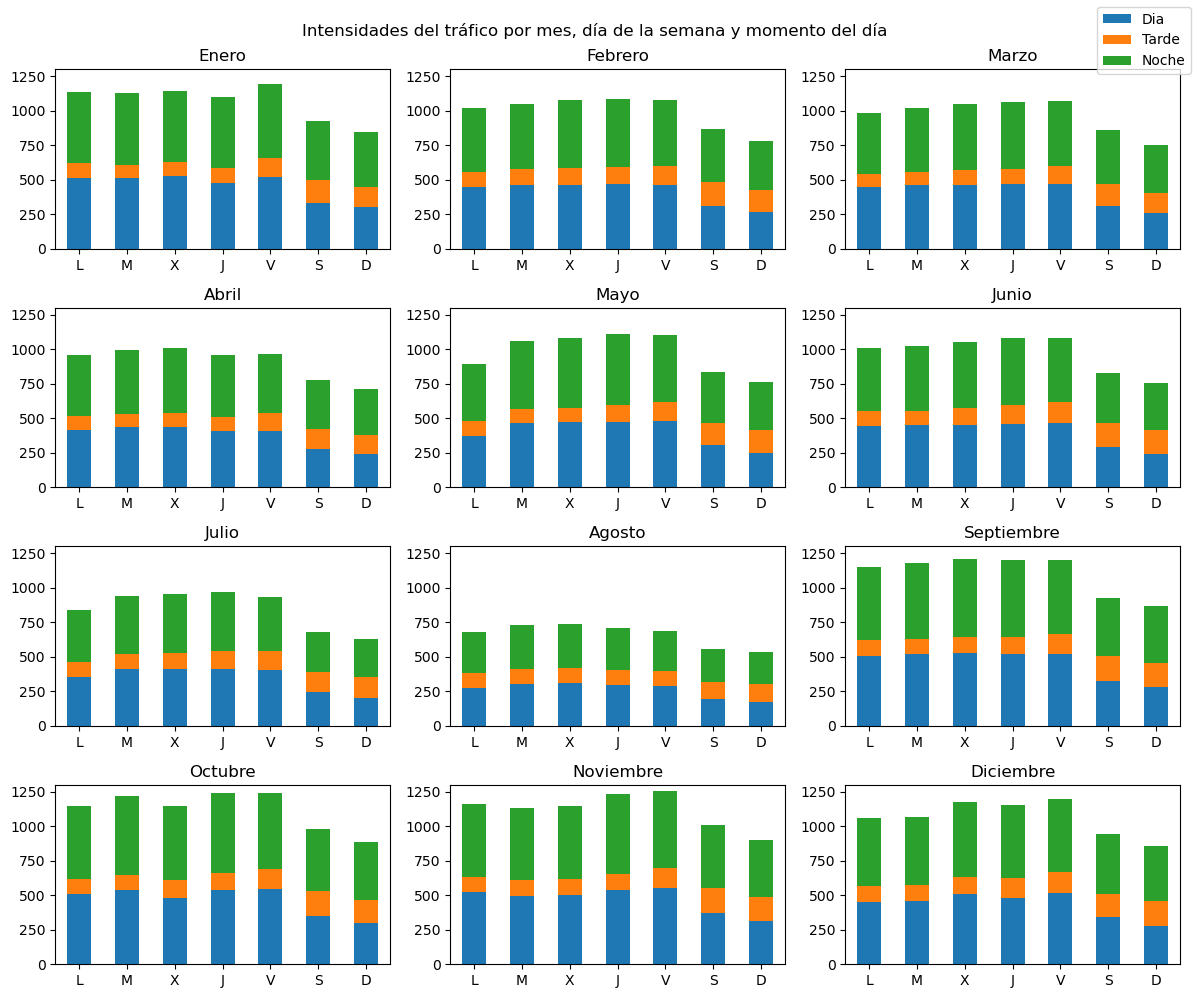

In [180]:
num_types = len(df_semanas2["month"].unique())
fig, axes = plt.subplots(figsize=(12,10), nrows=4, ncols=3)
fig.suptitle("Intensidades del tráfico por mes, día de la semana y momento del día")
meses = ['Enero','Febrero', 'Marzo', 'Abril','Mayo','Junio','Julio',
         'Agosto','Septiembre','Octubre','Noviembre','Diciembre']
dias_labels = ['L','M','X','J','V','S','D']
# se aplanan los ejes
ax = axes.flatten()

# se itera sobre los grupos
for index, (mes, grupo) in enumerate(df_semanas2.groupby("month")):
    (grupo.pivot_table(index="dia_semana", columns="periodo_dia", values="intensidad", aggfunc="sum")
          .plot(kind="bar", stacked=True, ax=ax[index], rot=0, title=meses[index], xlabel=''))
    #ax[index].set_title(mes)
    #ax[index].set_xlabel('')
    ax[index].set_ylim([0, 1300])
    ax[index].set_xticks(ticks=np.unique(grupo['dia_semana']),
                         labels=dias_labels)
    ax[index].get_legend().remove()
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, ['Dia', 'Tarde', 'Noche'], ncols = 1, loc="upper right")

plt.tight_layout()
plt.show()